In [13]:
# ML-based Ticket Desirability Scoring Model using TensorFlow
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

In [14]:
# Connect to database and load all tickets
tables = ["tickets", "ticketsbsb", "ticketscon", "ticketsfb"]
conn = sqlite3.connect("tickets.db")
dfs = []
for table in tables:
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    df["sport_table"] = table
    dfs.append(df)
conn.close()

df_all = pd.concat(dfs, ignore_index=True)

# Drop rows with missing critical values
df_all = df_all.dropna(subset=["estimated_price", "section", "row", "date", "home_team", "away_team"])


In [ ]:
# Feature engineering

# Convert section values into numeric scores
def parse_section(section):
    try:
        sec = section.lower()  # Convert to lowercase for easier comparison
        if "floor" in sec:
            return 100         # Assign 100 for floor seats (usually premium)
        if sec in ("ga", "general admission"):
            return 200         # Assign 200 for general admission
        return int(sec)        # Try to parse as a number (e.g., "101", "203")
    except:
        return 300             # Fallback value if parsing fails

# Convert row values into a consistent numeric format
def parse_row(row):
    row = str(row).strip().upper()  # Normalize row string (e.g., "A", "12", "AA")
    if row.isdigit():
        return int(row)             # Use number directly if it's a digit
    row = ''.join(filter(str.isalpha, row))  # Keep only letters
    if not row:
        return 50                   # Default if row is missing or empty
    value = 0
    for c in row:
        # Convert alphabetical row labels to a number (like Excel column logic)
        # A = 1, B = 2, ..., Z = 26, AA = 27, AB = 28, etc.
        value = value * 26 + (ord(c) - ord('A') + 1)
    return value

# Apply section and row parsing to create numeric features
df_all["section_num"] = df_all["section"].apply(parse_section)
df_all["row_num"] = df_all["row"].apply(parse_row)

# Ensure estimated_price is numeric for scoring logic
df_all["estimated_price"] = df_all["estimated_price"].astype(float)

# Normalize scores within each event to account for varying price levels
df_all["event_id"] = df_all["date"] + "_" + df_all["home_team"] + "_" + df_all["away_team"]

# Rank tickets by estimated price within each event (lower price = higher rank)
df_all["rank_within_event"] = df_all.groupby("event_id")["estimated_price"].rank(pct=True)

# Convert rank to a desirability score from 0.0 (worst) to 10.0 (best)
df_all["score_10"] = (1 - df_all["rank_within_event"]) * 10


In [ ]:
# Prepare features for the machine learning model

# Define which features are categorical and which are numeric
cat_features = ["section_num", "row_num"]      # Categorical features: seat location info
num_features = ["estimated_price"]             # Numeric feature: value-based pricing

# Create a new DataFrame that includes only the model input features and the target (score_10)
data = df_all[cat_features + num_features + ["score_10"]].copy()

# Label encode the categorical features (convert them to numeric values)
encoders = {}                                  # Dictionary to store encoders for each categorical column
for col in cat_features:
    le = LabelEncoder()                        # Initialize label encoder
    data[col] = le.fit_transform(data[col])    # Fit and transform the feature to numeric
    encoders[col] = le                         # Store encoder for potential reuse later (e.g. for predictions)

# Normalize numeric features to a 0–1 range (important for neural networks)
scaler = MinMaxScaler()                        # Initialize scaler
data[num_features] = scaler.fit_transform(data[num_features])  # Apply scaling


In [17]:
# Train/test split
X = data[cat_features + num_features]
y = data["score_10"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build TensorFlow model
inputs = []
embeddings = []

for col in cat_features:
    vocab_size = data[col].nunique()
    input_layer = Input(shape=(1,), name=col)
    embed = Embedding(input_dim=vocab_size + 1, output_dim=4)(input_layer)
    embed = Flatten()(embed)
    inputs.append(input_layer)
    embeddings.append(embed)

num_input = Input(shape=(len(num_features),), name="num_input")
inputs.append(num_input)

In [ ]:
# Combine all inputs (embedding layers + numeric inputs) into one layer
x = Concatenate()(embeddings + [num_input])  # Flattened embeddings + normalized numeric features

# First hidden layer with 64 neurons and ReLU activation
x = Dense(64, activation="relu")(x)

# Dropout helps prevent overfitting by randomly disabling 30% of the neurons during training
x = Dropout(0.3)(x)

# Second hidden layer with 32 neurons
x = Dense(32, activation="relu")(x)

# Another dropout layer to improve generalization (disable 20% randomly during training)
x = Dropout(0.2)(x)

# Output layer with 1 neuron and sigmoid activation to scale output between 0 and 1
output = Dense(1, activation="sigmoid")(x)

# Build the final model object with input definitions and output layer
model = Model(inputs=inputs, outputs=output)

# Compile the model with mean squared error loss (suitable for continuous output) and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Prepare model input dictionaries for training
# Categorical inputs
train_inputs = {col: np.array(X_train[col]) for col in cat_features}
val_inputs = {col: np.array(X_val[col]) for col in cat_features}

# Add the normalized numeric input under a special key
train_inputs["num_input"] = np.array(X_train[num_features])
val_inputs["num_input"] = np.array(X_val[num_features])

# Train the model
# Note: divide y values by 10 so model learns values in range [0, 1] (matches sigmoid output)
model.fit(
    train_inputs, 
    y_train / 10.0, 
    validation_data=(val_inputs, y_val / 10.0), 
    epochs=50, 
    batch_size=128
)

# Save trained model and encoders for future use
model.save("ticket_score_model_tf.keras")       # Save the full model in .keras format
joblib.dump(encoders, "encoders.pkl")           # Save label encoders for categorical columns
joblib.dump(scaler, "scaler.pkl")               # Save the scaler used for numeric input normalization

print("Model training complete. Saved as 'ticket_score_model_tf' with encoders and scaler.")


Epoch 1/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0504 - val_loss: 0.0259
Epoch 2/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0267 - val_loss: 0.0221
Epoch 3/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0233 - val_loss: 0.0195
Epoch 4/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0206 - val_loss: 0.0177
Epoch 5/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0190 - val_loss: 0.0166
Epoch 6/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 7/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0156
Epoch 8/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - val_loss: 0.0153
Epoch 9/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 10/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 11/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0167 - val_loss: 0.0149
Epoch 12/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [19]:
# --- Score all listings using the trained model ---
all_inputs = {col: np.array(data[col]) for col in cat_features}
all_inputs["num_input"] = np.array(data[num_features])

predictions = model.predict(all_inputs)
df_all["predicted_score_10"] = (predictions.flatten() * 10).round(1)

# Trim unnecessary columns for output
output_cols = [
    "id", "date", "home_team", "away_team", "section", "row",
    "price", "estimated_price", "url", "source", "created_at", "predicted_score_10"
]
df_all[output_cols].to_csv("scored_tickets.csv", index=False)
print("All ticket listings scored and saved to scored_tickets.csv")


3109/3109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
All ticket listings scored and saved to scored_tickets.csv


Score distribution chart saved as 'score_distribution_chart.png'


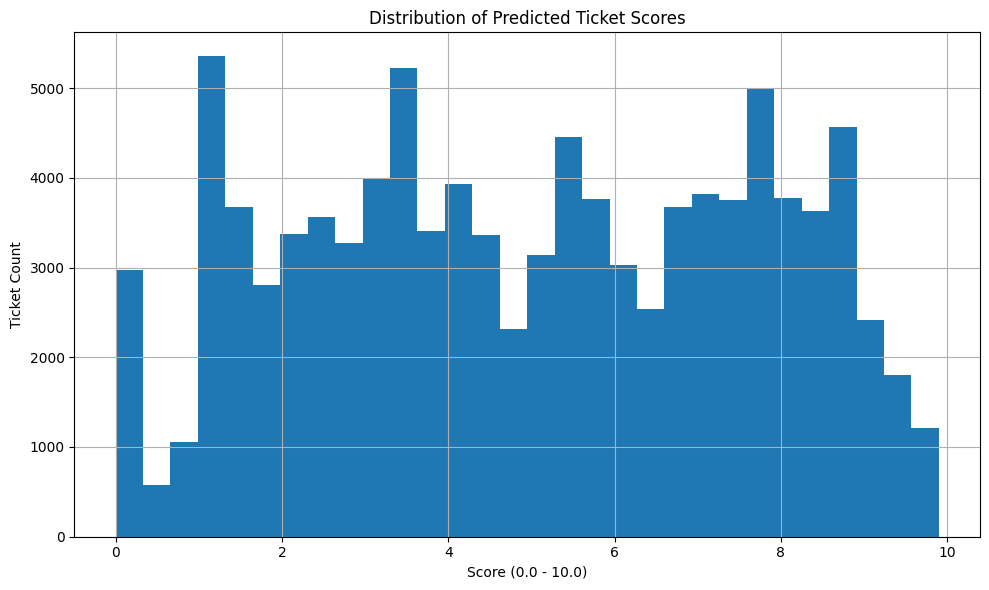

In [ ]:
# Visualization 
plt.figure(figsize=(10, 6))
df_all["predicted_score_10"].hist(bins=30)
plt.title("Distribution of Predicted Ticket Scores")
plt.xlabel("Score (0.0 - 10.0)")
plt.ylabel("Ticket Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution_chart.png")
print("Score distribution chart saved as 'score_distribution_chart.png'")
